In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
import re
import string
import spacy

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tqdm import tqdm
from tqdm._tqdm_notebook import tqdm_notebook

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
import pickle
import os
from sklearn import metrics

tqdm_notebook.pandas()

sns.set_style('darkgrid')

In [2]:
df1=pd.read_excel('Incident + Standard Request List Report_internal_SNOW_EU.xlsx', sheet_name=0,header=1)
df2=pd.read_excel('SNOW_Incident + Standard Request List Report_internal_Asia.xlsx', sheet_name=0,header=1)

C:\Users\A715809\AppData\Local\Continuum\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\Users\A715809\AppData\Local\Continuum\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [3]:
df=df1.append(df2)

In [4]:
df=df1

In [5]:
df.head()

,Company,Ticket Number,External ID,Ticket Type,Atos Subcategory 1,Atos Subcategory 2,Configuration Item,Severity,System,Application,...,Site,Solution,Primary Root Cause,Cause Code (Sub Level 1),Incident Resolution Code,Has Attached Knowledge,Incident Include in Reports,Last Modified Date,Aging until 2/15/22,Days between Last Modified and 2/15/22
0,Siemens.AMS4ER.AAE,INC018409152,INC11085957,INC,Local Application EU1,HR ESP Web,SPIRIDON(AP0),4,NaN,SPIRIDON(AP0),...,SIEMS.IN.Pune.PUN AA,No Customer Response / Aucune réponse du clien...,Other,Unable to find fault,Repaired,No,Yes,2022-02-07 02:35:45,483,8
1,Siemens.AMS4ER.AAE,INC024322537,INC13502774,INC,Local application EU2,OCC Distributori,NaN,2,NaN,NaN,...,SIEMS.QA.Doha.DOH AM,NaN,NaN,NaN,NaN,No,Yes,2021-08-10 06:28:53,196,189
2,Siemens.AMS4ER.AAE,INC024432152,INC13546467,INC,Local application EU2,OCC Distributori,NaN,4,NaN,NaN,...,SIEMS.QA.Doha.DOH AM,NaN,NaN,NaN,NaN,No,Yes,2021-09-01 12:00:26,190,167
3,Siemens.AMS4ER.AAE,INC025459557,INC13955217,SSR,Local application EU2,Kofax SSR,Generic_Siemens_MMSA,4,NaN,Generic_Siemens_MMSA,...,SIEMS.MY.Petaling jaya.PLJ,"Dear Danial, \n\nAs Company code 462X is rel...",HumanError,Atos,Information/advice given,No,Yes,2022-01-24 18:11:23,145,22
4,Siemens.AMS4ER.AAE,INC025574716,INC14001667,SSR,Local application EU2,Kofax SSR,Generic_Siemens_MMSA,4,NaN,Generic_Siemens_MMSA,...,SIEMS.KW.Kuwait.KWI A,\r\n\r\nSince there is nothing we can do from ...,Application,Opened in error,Invalid or Withdrawn,No,Yes,2022-01-26 23:34:03,140,20


In [6]:
df=df[['Short Description','Description','Group']]

In [7]:
df.describe()

,Short Description,Description,Group
count,8163,8163,8162
unique,7008,7579,67
top,Please create user in MyHR,"5355 - OOO Siemens, On a weekly basis Idocs s...",IN.AppsMgmt.SAP.FIN-FI
freq,84,21,1564


In [8]:
df.shape

(8163, 3)

In [9]:
non_dupl = df[~df.duplicated()].copy()
non_dupl.shape

(7773, 3)

In [10]:
non_dupl.dropna(inplace=True)
non_dupl.shape

(7772, 3)

In [11]:
# non_dupl['Short Description'] = non_dupl['Short Description'][
#     non_dupl['Short Description'].apply(lambda x: len(x.split()) > 2) == True]
# non_dupl.shape

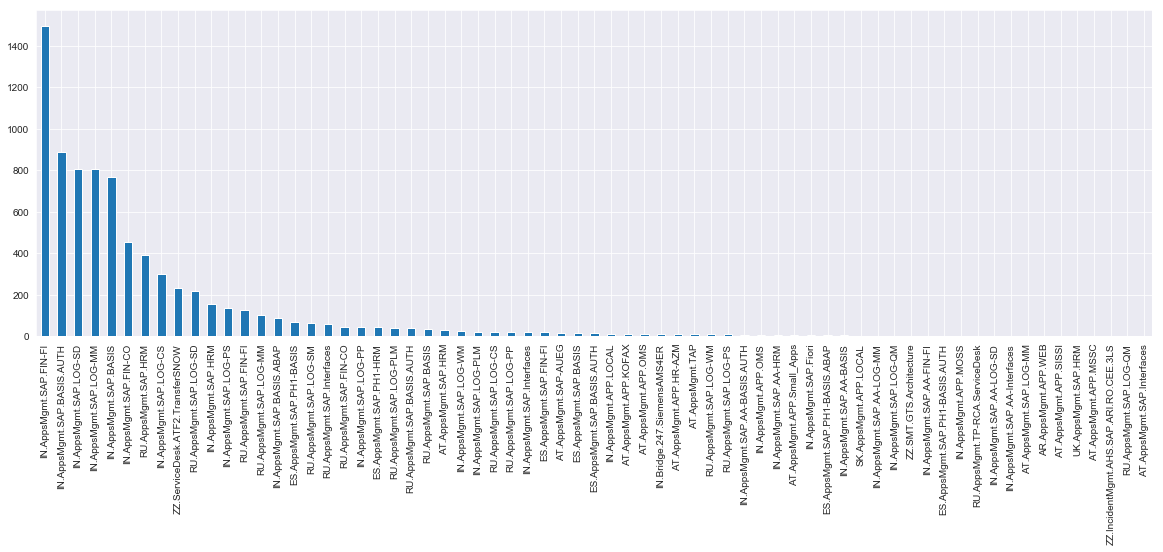

In [12]:
cnt_asgn_grps = non_dupl['Group'].value_counts()

cnt_asgn_grps.plot(kind='bar', figsize=(20, 6))
plt.show()

In [13]:
cnt_asgn_grps[:60]

IN.AppsMgmt.SAP.FIN-FI              1496
IN.AppsMgmt.SAP.BASIS.AUTH           889
IN.AppsMgmt.SAP.LOG-SD               808
IN.AppsMgmt.SAP.LOG-MM               807
IN.AppsMgmt.SAP.BASIS                766
IN.AppsMgmt.SAP.FIN-CO               455
RU.AppsMgmt.SAP.HRM                  392
IN.AppsMgmt.SAP.LOG-CS               299
ZZ.ServiceDesk.ATF2.TransferSNOW     234
RU.AppsMgmt.SAP.LOG-SD               219
IN.AppsMgmt.SAP.HRM                  155
IN.AppsMgmt.SAP.LOG-PS               134
RU.AppsMgmt.SAP.FIN-FI               125
RU.AppsMgmt.SAP.LOG-MM               102
IN.AppsMgmt.SAP.BASIS.ABAP            89
ES.AppsMgmt.SAP.PH1-BASIS             69
RU.AppsMgmt.SAP.LOG-SM                66
RU.AppsMgmt.SAP.Interfaces            59
RU.AppsMgmt.SAP.FIN-CO                47
IN.AppsMgmt.SAP.LOG-PP                45
ES.AppsMgmt.SAP.PH1-HRM               44
RU.AppsMgmt.SAP.LOG-PLM               40
RU.AppsMgmt.SAP.BASIS.AUTH            39
RU.AppsMgmt.SAP.BASIS                 35
AT.AppsMgmt.SAP.

In [14]:
cnt_asgn_grps.min(), cnt_asgn_grps.max()

(1, 1496)

In [15]:
counts = sorted(cnt_asgn_grps, reverse=True)
len([f for f in counts if f > 100])

14

In [16]:
cnts = non_dupl['Group'].value_counts()
valid_labels=cnts[cnts > 100]

In [17]:
test_df = non_dupl[non_dupl['Group'].isin(valid_labels.index.to_list())]

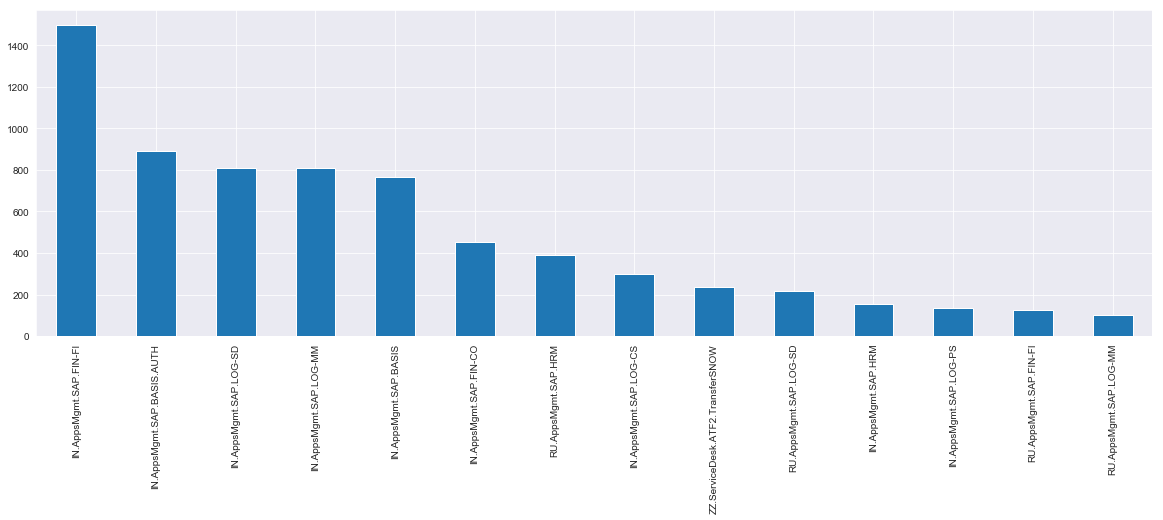

In [18]:
test_df['Group'].value_counts().plot(kind='bar', figsize=(20, 6))
plt.show()

In [19]:
max_class = test_df[test_df['Group']=='IN.AppsMgmt.SAP.FIN-FI']

In [20]:
max_class = max_class.sample(900)

In [21]:
test_df = test_df[~test_df['Group'].isin(['IN.AppsMgmt.SAP.FIN-FI'])]

In [22]:
test_df = test_df.append(max_class)
test_df = test_df.sample(frac=1)

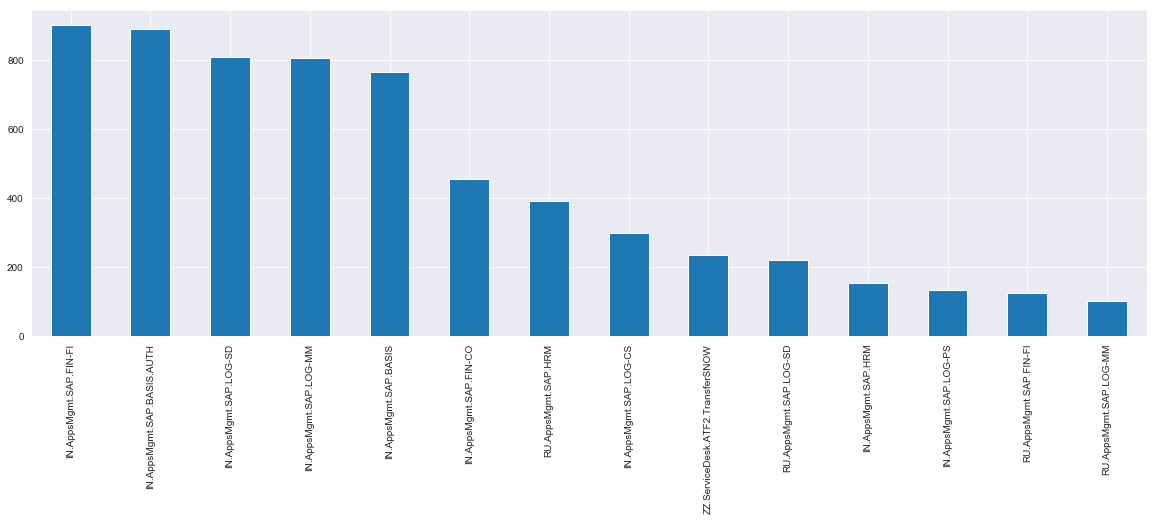

In [23]:
test_df['Group'].value_counts().plot(kind='bar', figsize=(20, 6))
plt.show()

In [24]:
test_df['Short Description'].isna().sum()

0

In [25]:
test_df.shape

(6285, 3)

In [26]:
#test_df.dropna(subset = ['Short Description'], inplace=True)

In [27]:
#test_df.shape

In [28]:
print(valid_labels)

IN.AppsMgmt.SAP.FIN-FI              1496
IN.AppsMgmt.SAP.BASIS.AUTH           889
IN.AppsMgmt.SAP.LOG-SD               808
IN.AppsMgmt.SAP.LOG-MM               807
IN.AppsMgmt.SAP.BASIS                766
IN.AppsMgmt.SAP.FIN-CO               455
RU.AppsMgmt.SAP.HRM                  392
IN.AppsMgmt.SAP.LOG-CS               299
ZZ.ServiceDesk.ATF2.TransferSNOW     234
RU.AppsMgmt.SAP.LOG-SD               219
IN.AppsMgmt.SAP.HRM                  155
IN.AppsMgmt.SAP.LOG-PS               134
RU.AppsMgmt.SAP.FIN-FI               125
RU.AppsMgmt.SAP.LOG-MM               102
Name: Group, dtype: int64


In [29]:
test_df['Description']=test_df['Short Description']+test_df['Description']

In [30]:
from bs4 import BeautifulSoup

# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've","you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself','she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their','theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those','am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does','did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of','at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after','above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further','then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more','most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very','s', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're','ve', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',"hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',"mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't",'won', "won't", 'wouldn', "wouldn't"])

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

print("Data Pre-Processing")
preprocessed_descriptions = []
# tqdm is for printing the status bar
for sentance in tqdm(test_df['Description'].values):
#     sent = sentance.split("-- Original Text --")
#     sentance = sent[0]
#     sentance = re.sub("-- Translated from ([A-Za-z ]*) --","", sentance)
    sentance = re.sub("(\\W)+"," ",sentance)
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_descriptions.append(sentance.strip())
test_df['Description'] = preprocessed_descriptions

Data Pre-Processing


100%|████████████████████████████████████████████████████████████████████████████| 6285/6285 [00:03<00:00, 1691.66it/s]


In [31]:
test_df.head()

,Short Description,Description,Group
7291,Red:SWP_100:/SIE/SWE/Z003ZJ0S/170632:Z003ZJ0S,red sie swe team observed mentioned job cancel...,IN.AppsMgmt.SAP.LOG-CS
771,Red : MP1_400 : Cancelled Job : J400_RVV05IV...,red cancelled job team mentioned job got cance...,IN.AppsMgmt.SAP.LOG-SD
5491,Docs sup.1402 were stacked in failed. Please u...,docs sup stacked failed please unlock send e o...,RU.AppsMgmt.SAP.LOG-SD
3082,Yellow : SPP : Expensive Statement,yellow spp expensive statementhello team obser...,IN.AppsMgmt.SAP.BASIS
5968,New sales office for sales org. 50L0,new sales office sales org siemens p italy dea...,IN.AppsMgmt.SAP.LOG-SD


In [32]:
new_df=test_df[['Description','Group']]
new_df.head()

,Description,Group
7291,red sie swe team observed mentioned job cancel...,IN.AppsMgmt.SAP.LOG-CS
771,red cancelled job team mentioned job got cance...,IN.AppsMgmt.SAP.LOG-SD
5491,docs sup stacked failed please unlock send e o...,RU.AppsMgmt.SAP.LOG-SD
3082,yellow spp expensive statementhello team obser...,IN.AppsMgmt.SAP.BASIS
5968,new sales office sales org siemens p italy dea...,IN.AppsMgmt.SAP.LOG-SD


In [33]:
new_df.to_csv('new_balanced_data_50_preprocessed10.csv', index=False)

In [34]:
df = pd.read_csv('new_balanced_data_50_preprocessed10.csv')

In [35]:
df.dropna(subset = ['Description'], inplace=True)

In [36]:
df['Description'] = df['Description'][df['Description'].apply(lambda x: len(x.split()) > 2) == True]

In [37]:
df['Description'].isna().sum()

2

In [38]:
df.dropna(subset = ['Description'], inplace=True)
df.shape

(6278, 2)

In [39]:
text = ' '.join(df['Description'])

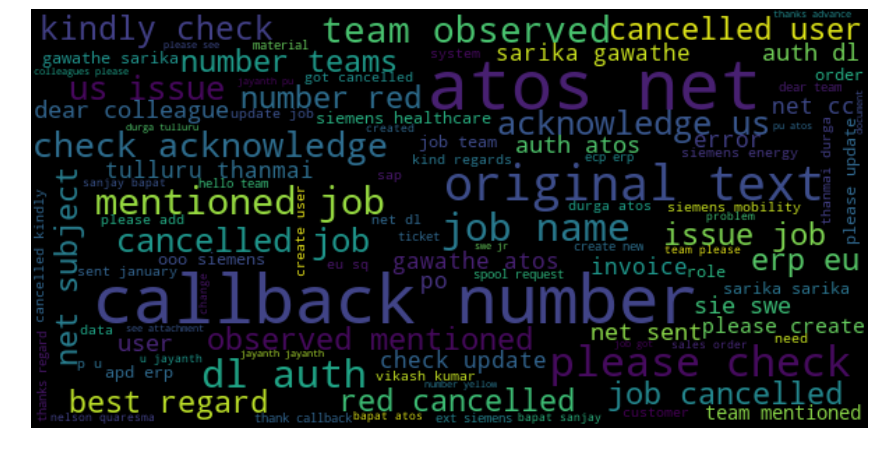

In [40]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
# Create and generate a word cloud image:
wordcloud = WordCloud(width=600,height=300,max_font_size=50, max_words=100).generate(text)

# Display the generated image:
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [41]:
from sklearn.model_selection import train_test_split
BALANCING="ROS"
print("Balancing Techinque :"+BALANCING)
#print("Train-Test Split "+str((1-TESTSIZE)*100)+":"+str(TESTSIZE*100))
if BALANCING=="SMOTE" or BALANCING=="RUS":
    X_train, X_test, y_train, y_test = train_test_split(df, 
                                                    df['Group'], 
                                                    test_size=0.20, 
                                                    random_state=42)
if BALANCING=="ROS":
    X_train, X_test, y_train, y_test = train_test_split(df['Description'], 
                                                    df['Group'], 
                                                    test_size=0.20, 
                                                    random_state=42)

print("Training data points :"+str(len(X_train)))
print("Testing data points :"+str(len(X_test)))

Balancing Techinque :ROS
Training data points :5022
Testing data points :1256


In [42]:
from imblearn.under_sampling import RandomUnderSampler
TEXT_COLUMN_PROCESSED='Description'
# transform the dataset
if BALANCING=="ROS":
    oversample = RandomOverSampler()
    tf_idf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 3), stop_words=stopwords)
    X_train1 = tf_idf.fit_transform(X_train)
    X, y = oversample.fit_resample(X_train1, y_train.ravel())

if BALANCING=="SMOTE":
    oversample = SMOTE()
    tf_idf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1,3), stop_words='english')
    X_train1 = tf_idf.fit_transform(X_train[TEXT_COLUMN_PROCESSED])
    X, y = oversample.fit_resample(X_train1, y_train.ravel())

if BALANCING=="RUS":
    rus = RandomUnderSampler()
    tf_idf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 3), stop_words=stopwords)
    X_train1 = tf_idf.fit_transform(X_train[TEXT_COLUMN_PROCESSED]).toarray()
    X, y = rus.fit_resample(X_train1, y_train.ravel())

In [43]:
print("Selecting Best Model")
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0,n_jobs=-1),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0,n_jobs=-1),
    ExtraTreesClassifier(n_estimators=100, random_state=0,n_jobs=-1)
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
model_names=[]
for model in tqdm(models):
    model_name = model.__class__.__name__
    model_names.append(model_name)
    accuracies = cross_val_score(model, X, y, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

Selecting Best Model


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:01<00:00, 12.31s/it]


In [44]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
        ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']

In [45]:
print("Best Model Selected {}".format(acc['Mean Accuracy'].idxmax()))
model = models[model_names.index(acc['Mean Accuracy'].idxmax())]
# model = LogisticRegression(random_state=0,n_jobs=-1)
model.fit(X, y)
if BALANCING=="SMOTE" or BALANCING=="RUS":
    test_features = tf_idf.transform(X_test[TEXT_COLUMN_PROCESSED]).toarray()
if BALANCING=="ROS":
    test_features = tf_idf.transform(X_test).toarray()
print("Predicting on Test data")
y_pred = model.predict(test_features)

Best Model Selected LinearSVC
Predicting on Test data


In [46]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred, target_names= y_test.unique()))

				CLASSIFICATIION METRICS

                                  precision    recall  f1-score   support

          RU.AppsMgmt.SAP.FIN-FI       0.77      0.68      0.73       168
          IN.AppsMgmt.SAP.LOG-CS       0.93      0.78      0.85       193
           IN.AppsMgmt.SAP.BASIS       0.74      0.76      0.75        98
          IN.AppsMgmt.SAP.LOG-MM       0.58      0.68      0.63       192
      IN.AppsMgmt.SAP.BASIS.AUTH       0.78      0.60      0.68        35
          IN.AppsMgmt.SAP.FIN-FI       0.70      0.80      0.75        50
             IN.AppsMgmt.SAP.HRM       0.69      0.76      0.73       143
          IN.AppsMgmt.SAP.FIN-CO       0.61      0.61      0.61        23
          IN.AppsMgmt.SAP.LOG-SD       0.70      0.63      0.66       155
             RU.AppsMgmt.SAP.HRM       0.76      0.62      0.68        21
          RU.AppsMgmt.SAP.LOG-MM       0.88      0.96      0.92        77
          RU.AppsMgmt.SAP.LOG-SD       0.38      0.38      0.38        13
ZZ.Servi

In [47]:
import pickle
import os
OUT_MODEL_NAME="automated_model1.pkl"
OUT_VEC_NAME="automated_tfidf1.pkl"
OUTDIR="output"
print("Saving Model")
if OUTDIR!="":
    pickle.dump(model, open(os.path.join(OUTDIR,OUT_MODEL_NAME), 'wb'))

    pickle.dump(tf_idf, open(os.path.join(OUTDIR,OUT_VEC_NAME), 'wb'))
else:
    pickle.dump(model, open(OUT_MODEL_NAME, 'wb'))

    pickle.dump(tf_idf, open(OUT_VEC_NAME, 'wb'))
print("Model Saved")

Saving Model
Model Saved


In [48]:
desc = "Cannot access https://pd.siemens.com.sg/ (KOFAX FINANCE DIRECTOR) using my PKI , Cannot access https://pd.siemens.com.sg/ (KOFAX FINANCE DIRECTOR) using my PKI Error Message: 403 - Forbidden: Access is denied.You do not have permission to view this directory or page using the credentials that you supplied. Callback Number :"
print("Data Pre-Processing")
sentance = desc
# tqdm is for printing the status bar
sentance = re.sub("(\\W)+"," ",sentance)
sentance = re.sub(r"http\S+", "", sentance)
sentance = BeautifulSoup(sentance, 'lxml').get_text()
sentance = decontracted(sentance)
sentance = re.sub("\S*\d\S*", "", sentance).strip()
sentance = re.sub('[^A-Za-z]+', ' ', sentance)
# https://gist.github.com/sebleier/554280
sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
sentance = sentance.strip()
print(sentance)

Data Pre-Processing
cannot access pd siemens com sg kofax finance director using pki cannot access pd siemens com sg kofax finance director using pki error message forbidden access denied not permission view directory page using credentials supplied callback number


In [49]:
test_features = tf_idf.transform([sentance]).toarray()
y_pred = model.predict(test_features)
print(desc+" => "+y_pred[0])

Cannot access https://pd.siemens.com.sg/ (KOFAX FINANCE DIRECTOR) using my PKI , Cannot access https://pd.siemens.com.sg/ (KOFAX FINANCE DIRECTOR) using my PKI Error Message: 403 - Forbidden: Access is denied.You do not have permission to view this directory or page using the credentials that you supplied. Callback Number : => ZZ.ServiceDesk.ATF2.TransferSNOW
